In [68]:
from IPython.display import Image

# (이전 주차) 테스트 유닛

In [3]:
import unittest
import numpy as np
import pandas as pd

def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data) / (2 * eps)

class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)

    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)

    def test_gradient_check(self):
        x = Variable(np.random.rand(1))
        y = square(x)
        y.backward()
        num_grad = numerical_diff(square, x)
        fig = np.allclose(x.grid, num_grad)
        self.assertTrue(fig)

## 모듈 import / variable 가져오기

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is noe surpported')
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)   # self.data와 self.grad의 타입을 맞춤

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)

            if x.creator is not None:
                funcs.append(x.creator)

# 챕터 11 가변 길이 인수 (순전파)

In [33]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

In [32]:
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [36]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

In [39]:
def add(x0, x1):
    return Add()(x0, x1)

In [41]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))

add(x0, x1).data

array(5)

# 챕터 13 가변 길이 인수 (역전파)

In [63]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is noe surpported')
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)   # self.data와 self.grad의 타입을 맞춤

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
            for x, gx in zip(f.inputs, gxs):
                if x. grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

            if x.creator is not None:
                funcs.append(x.creator)

    def cleargrad(self):
        self.grad = None

In [79]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    def backward(self, gy):
        return gy, gy

In [77]:
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx

def square(x):
    return Square()(x)

In [49]:
x = Variable(np.array(2))
y = Variable(np.array(3))

z = add(square(x), square(y))
z.backward()

print(z.data, x.grad, y.grad, sep = '\n')

13
None
6


In [60]:
x = Variable(np.array(2))
add(x, x).backward()
print(x.grad)

2


In [64]:
x = Variable(np.array(2))
y = add(x, x)
y.backward()
print('1. x.grad = ', x.grad)

x.cleargrad()
y = add(x, x)
y.backward()
print('2. x.grad = ', x.grad)

1. x.grad =  2
2. x.grad =  2


# 챕터 15 복잡한 계산 그래프 (이론)

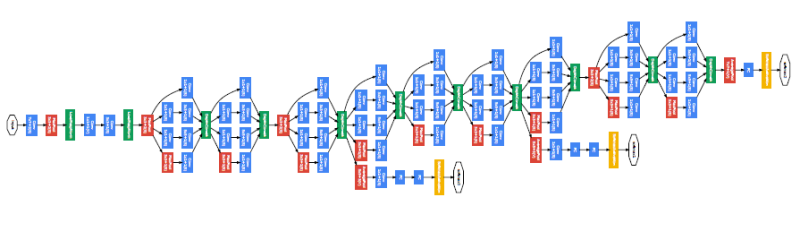

In [69]:
Image("googlenet.png")

## 2개의 분기가 있는 그래프를 역전파할 때

* 처음에 갈라지는 분기로 돌아갈 때, 두 갈래의 역전파 경로가 합쳐져 같이 진행되어야 한다
* 그렇지 않으면 분기가 합쳐지지 않고 동일한 노드에서 역전파가 2회 이상 일어나게 됨
* 따라서 **함수 우선 순위**를 설정하여야 함
* 이는 '세대'를 설정하는 것을 말함
* 이를 통해 부모보다 자식이 먼저 처리됨을 보장할 수 있음

# 챕터 16 세대 추가

* 역전파 시 노드들이 꼬이지 않게 하기 위함

## 세대 순으로 꺼내는 방법

* generation 클래스를 sort함을 통해 pop에서 꺼내지는 개체가 세대의 역순으로 꺼내지도록 한다
* [f.generation for f in funcs] <- 예제 코드
  

In [75]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is noe surpported')
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)   # self.data와 self.grad의 타입을 맞춤

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
            for x, gx in zip(f.inputs, gxs):
                if x. grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

            if x.creator is not None:
                add_func(x.creator)

    def cleargrad(self):
        self.grad = None

In [76]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

In [80]:
x = Variable(np.array(2.0))
a = square(x)
y = add(square(a), square(a))
y.backward()

print('y.data = ', y.data)
print('x.grad = ', x.grad)

y.data =  32.0
x.grad =  32.0


# 챕터 17 메모리 관리와 순환 참조

* 코드 작성에 따라 메모리 누수, 메모리 부족 현상이 나타남
* 신경망은 큰 데이터를 다루기 때문에 메모리 관리를 잘 해 주어야 함
* 파이썬의 메모리 관리 방식: 참조(reference)수 세기 / 세대를 기준으로 쓸모없어진 개체 회수하기

## 참조 카운터

* 파이썬 메모리 관리의 기본적인 방식
* 모든 객체는 참조 카운트 0인 상태로 생성, 다른 객체가 참조하면 카운트가 증가한다
* 객체에 대한 참조가 끊길 때마다 참조가 감소하며, 0이 되면 객체를 회수

## 순환 참조

* 서로가 서로를 참조하는 형식
* 참조 카운터 형식의 약점

## GC garbage collection

* 메모리가 부족해지는 시점에 인터프리터에 의해 자동으로 호출됨
* GC에 할당 해제를 미루면 메모리 사용량이 커지게 됨
* 따라서 순환 참조를 만들지 않는 것이 가장 좋음

그래서 등장한

## 약한 참조 (weak reference)

* 다른 객체는 참조하되 참조 카운터는 증가시키지 않는 기능
* 파이썬에서는 weakref.ref 함수를 사용
* 예시

In [1]:
import weakref
import numpy as np
a = np.array([1, 2, 3])
b = weakref.ref(a)
b

<weakref at 0x0000029F6A48E070; to 'numpy.ndarray' at 0x0000029F6B082DF0>

In [2]:
a = None
b

<weakref at 0x0000029F6A48E070; dead>

___________
 ### 실습

In [3]:
import weakref
import numpy as np

In [4]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

In [23]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is not surpported')
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def backward(self, retain_grad = False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)   # self.data와 self.grad의 타입을 맞춤
        
        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
            for x, gx in zip(f.inputs, gxs):
                if x. grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

            if x.creator is not None:
                add_func(x.creator)

        if not retain_grad:
            for y in f.outputs:
                y().grad = None


    def cleargrad(self):
        self.grad = None

In [74]:
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx

def square(x):
    return Square()(x)

class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    def backward(self, gy):
        return gy, gy

def add(x0, x1):
    return Add()(x0, x1)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [10]:
for i in range(10):
    x = Variable(np.random.randn(10000))
    y = square(square(square(x)))

In [17]:
y.data.mean()

103.59925231039455

# 챕터 18 메모리 절약 모드

## DeZero의 메모리 사용을 개선할 수 있는 구조

* 역전파 시 사용하는 메모리양을 줄이는 방법
* 역전파가 필요 없는 경우일 때의 모드를 제공

In [24]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()

print(y.grad, t.grad)
print(x1.grad, x1.grad)

1.0 None
1.0 1.0


In [25]:
class Config:
    enable_backprop = True

class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is not surpported')
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def backward(self, retain_grad = False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)   # self.data와 self.grad의 타입을 맞춤
        
        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
            for x, gx in zip(f.inputs, gxs):
                if x. grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

            if x.creator is not None:
                add_func(x.creator)

        if not retain_grad:
            for y in f.outputs:
                y().grad = None


    def cleargrad(self):
        self.grad = None

In [44]:
Config.enable_backprop = True # 중간 결과 저장
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))
y.backward()

In [31]:
Config.enable_backprop = False # 중간 결과 삭제
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))
y.backward()

## with 를 사용한 모드 전환 

In [33]:
import contextlib

In [35]:
# 기본형

@contextlib.contextmanager
def config_test():
    print('start')
    try:
        yield
    finally:
        print('done')

with config_test():
    print('process...')

start
process...
done


In [37]:
class Config:
    enable_backprop = True

@contextlib.contextmanager
def config_test(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    print('start')
    try:
        yield
    finally:
        print('done')

with config_test():
    print('process...')

def no_grad():
    return using_config('enable_backdrop', False)

with no_grad():
    x = Variable(np.array(2.0))
    y = square(x)

TypeError: config_test() missing 2 required positional arguments: 'name' and 'value'

In [46]:
class Config:
    enable_backprop = True

class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is not surpported')
        
        self.data = data
        self.name = None
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def backward(self, retain_grad = False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)   # self.data와 self.grad의 타입을 맞춤
        
        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
            for x, gx in zip(f.inputs, gxs):
                if x. grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

            if x.creator is not None:
                add_func(x.creator)

        if not retain_grad:
            for y in f.outputs:
                y().grad = None

    def cleargrad(self):
        self.grad = None

    def __mul__(self, other):
        return mul(self, other)

    Variable.__mul__ = mul
    Variable.__add__ = add

    @property #밑 메소드를 인스턴스 변수처럼 사용할 수 있게 함
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

## 인스턴스 변수처럼 사용하기

In [41]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(x.shape)
print(len(x))
print(x)

(2, 3)
2
variable([[1 2 3]
          [4 5 6]])


## 연산자 오버로드 -> + 와 * 지원하기

In [93]:
class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0

def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)

In [94]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

y = add(mul(a, b), c)
y.backward()

print(y)
print(a.grad)
print(b.grad)

variable(7.0)
None
None


In [95]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
y = a * b
print(y)

variable(6.0)


## ndarray와 함께 사용하기

In [96]:
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx

def square(x):
    return Square()(x)

class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    def backward(self, gy):
        return gy, gy

In [97]:
def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)

In [98]:
class Config:
    enable_backprop = True

class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is not surpported')
        
        self.data = data
        self.name = None
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def backward(self, retain_grad = False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)   # self.data와 self.grad의 타입을 맞춤
        
        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
            for x, gx in zip(f.inputs, gxs):
                if x. grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

            if x.creator is not None:
                add_func(x.creator)

        if not retain_grad:
            for y in f.outputs:
                y().grad = None

    def cleargrad(self):
        self.grad = None

    def __mul__(self, other):
        return mul(self, other)

    def __add__(self, other):
        return add(self, other)

    Variable.__mul__ = mul
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__rmul__ = mul
    __array_priority__ = 200

    @property #밑 메소드를 인스턴스 변수처럼 사용할 수 있게 함
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

In [100]:
x = Variable(np.array(2.0))
y = x * 5.0 + 4
print(y)

variable(14.0)


# 연산자들 추가

In [106]:
class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy

def neg(x):
    return Neg()(x)

Variable.__neg__ = neg

class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy

def sub(x0, x1):
    x1 = as_array(x)
    return Sub()(x0, x1)

Variable.__sub__ = sub

def rsub(x0, x1):
    x1 = as_array(x1)
    return sub(x1, x0)

Variable.__rsub__ = rsub

class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1

def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)

def rdiv(x0, x1):
    x1 = as_array(x1)
    return div(x1, x0)

Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv

class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c
        gx = c * x ** (c - 1) * gy
        return gx

def pow(x, c):
    return Pow(c)(x)

Variable.__pow__ = pow

In [107]:
x = Variable(np.array(5.0))
y = -x ** 3
print(y)

variable(-125.0)


# 7주차 : 고차 미분

In [1]:
import numpy as np
from mydezero.core import *
import sys

In [2]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

In [3]:
x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
gx.backward()
print(x.grad)

variable(24.0)
variable(24.0)


In [4]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
x.cleargrad()
gx.backward()
print(x.grad)

variable(24.0)
None


In [5]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)

    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data

0 variable(2.0)


AttributeError: 'NoneType' object has no attribute 'data'